In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=397b383df19e969d13472b0c3c8ccb6ab6976e047c3e61f08d6a7db96501b440
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


**This script trains and evaluates multiple deep learning models on the PneumoniaMNIST dataset using data augmentation, mixed-precision training, and multiple neural network architectures. The results are visualized to compare performance metrics such as accuracy, loss, and AUC**

==> Preparing data for pneumoniamnist with augmentations..
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
==> Initializing VGG16...
==> Initializing ResNet50...
==> Initializing ResNet18...
==> Initializing DenseNet...
==> Initializing ViT...

Training VGG16...


<ipython-input-3-06a3fb3a6947>:201: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training


[VGG16] Epoch 1/10 | Train Acc: 90.97% | Test Acc: 91.99% | AUC: 0.9782
Model saved to VGG16_model.pth
[VGG16] Epoch 2/10 | Train Acc: 94.88% | Test Acc: 94.71% | AUC: 0.9860
Model saved to VGG16_model.pth
[VGG16] Epoch 3/10 | Train Acc: 95.43% | Test Acc: 90.71% | AUC: 0.9577
Model saved to VGG16_model.pth
[VGG16] Epoch 4/10 | Train Acc: 95.94% | Test Acc: 89.10% | AUC: 0.9867
Model saved to VGG16_model.pth
[VGG16] Epoch 5/10 | Train Acc: 96.50% | Test Acc: 92.31% | AUC: 0.9877
Model saved to VGG16_model.pth
[VGG16] Epoch 6/10 | Train Acc: 97.81% | Test Acc: 92.95% | AUC: 0.9873
Model saved to VGG16_model.pth
[VGG16] Epoch 7/10 | Train Acc: 98.24% | Test Acc: 94.87% | AUC: 0.9893
Model saved to VGG16_model.pth
[VGG16] Epoch 8/10 | Train Acc: 98.41% | Test Acc: 93.59% | AUC: 0.9886
Model saved to VGG16_model.pth
[VGG16] Epoch 9/10 | Train Acc: 98.17% | Test Acc: 93.91% | AUC: 0.9886
Model saved to VGG16_model.pth
[VGG16] Epoch 10/10 | Train Acc: 98.56% | Test Acc: 95.35% | AUC: 0.9889


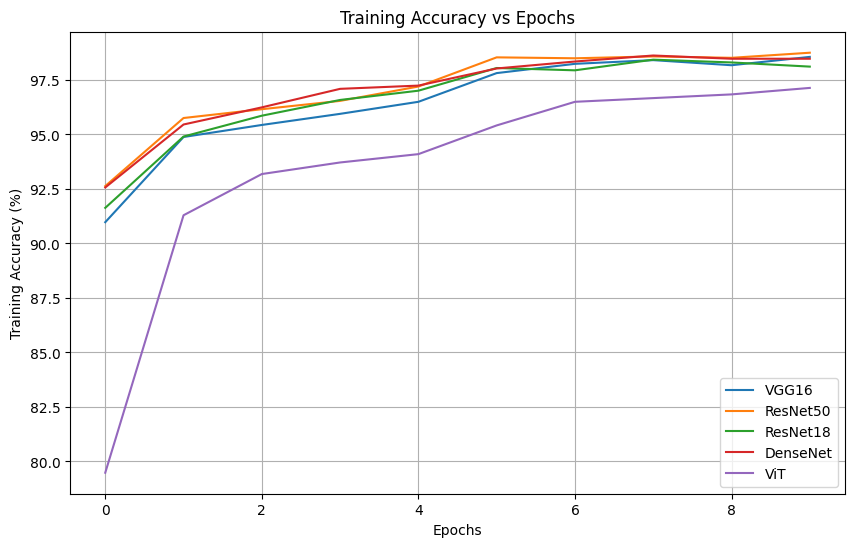

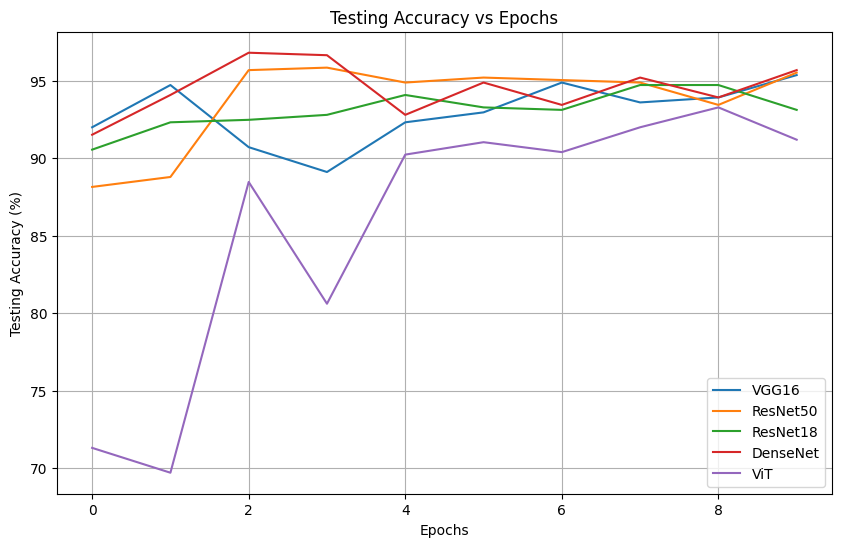

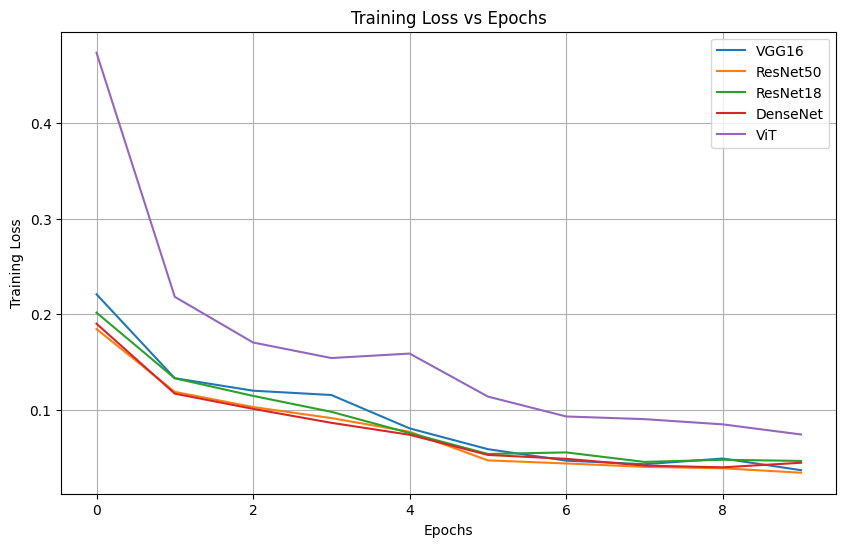

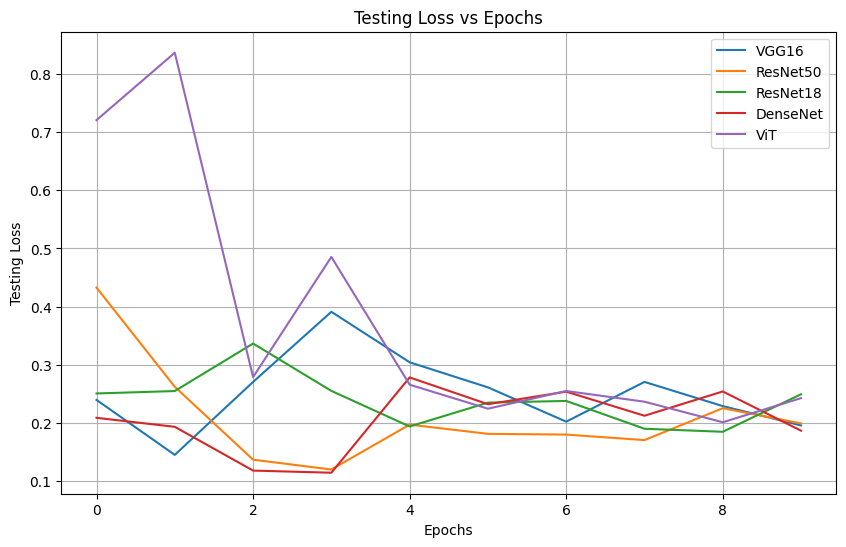

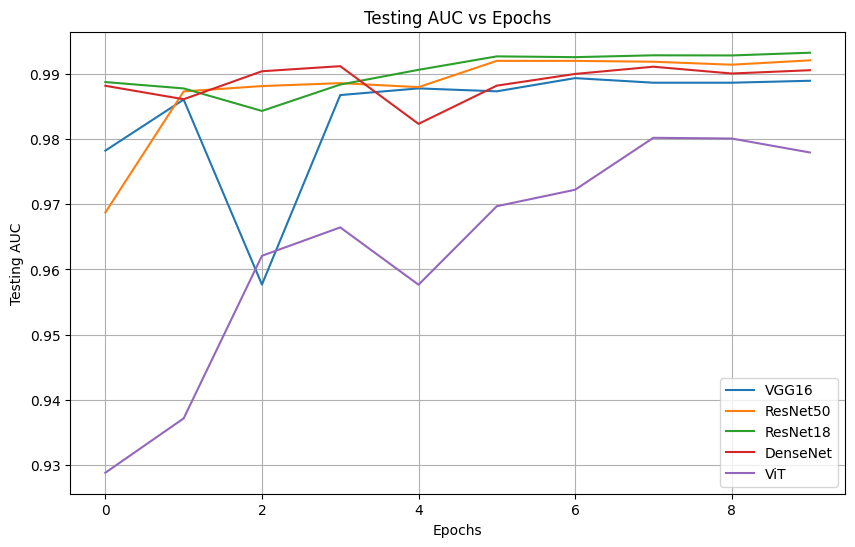

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision.models import resnet18, densenet121, vgg16, resnet50
from timm import create_model
from sklearn.metrics import roc_auc_score
import medmnist
from medmnist import INFO
import os
import matplotlib.pyplot as plt

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset handling
dataset_name = 'pneumoniamnist'
info = INFO[dataset_name]
DataClass = getattr(medmnist, info['python_class'])
classes = info['label']

print(f'==> Preparing data for {dataset_name} with augmentations..')

# Data augmentation for training
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Normal transformations for testing
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Data loaders for training and testing
train_data = DataClass(split='train', transform=transform_train, download=True, size=224)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)

test_data = DataClass(split='test', transform=transform_test, download=True, size=224)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

# Utility to handle NaN or Inf in tensors
def is_valid_tensor(tensor):
    return torch.isfinite(tensor).all()

# Training and Testing Functions
def train_model(model, optimizer, criterion, scheduler, num_epochs=10, model_name='Model', save_path=None):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []
    test_auc_list = []

    # Open the file for writing metadata (append mode to avoid overwriting)
    metadata_file = open("checkpoints/checkpoints_metadata.txt", "a")

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() > 1:  # Ensure targets are 1D
                targets = targets.squeeze(1)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):  # Mixed precision
                outputs = model(inputs)
                if not is_valid_tensor(outputs):
                    print(f"Skipping invalid outputs in training at epoch {epoch}")
                    continue

                loss = criterion(outputs, targets)
                if not is_valid_tensor(loss):
                    print(f"Skipping invalid loss in training at epoch {epoch}")
                    continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc_list.append(100. * correct / total)
        train_loss_list.append(train_loss / len(trainloader))

        # Testing
        model.eval()
        test_loss, correct, total = 0, 0, 0
        all_targets, all_preds = [], []

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                if targets.dim() > 1:
                    targets = targets.squeeze(1)

                outputs = model(inputs)
                if not is_valid_tensor(outputs):
                    print(f"Skipping invalid outputs in testing at epoch {epoch}")
                    continue

                loss = criterion(outputs, targets)
                if not is_valid_tensor(loss):
                    print(f"Skipping invalid loss in testing at epoch {epoch}")
                    continue

                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        test_acc_list.append(100. * correct / total)
        test_loss_list.append(test_loss / len(testloader))
        try:
            test_auc_list.append(roc_auc_score(all_targets, all_preds))
        except ValueError:  # Handle case where AUC calculation fails
            print(f"Skipping AUC calculation for epoch {epoch} due to invalid targets or predictions.")
            test_auc_list.append(0)

        scheduler.step()

        # Write the metadata to the text file
        metadata_file.write(f"Model: {model_name}, Epoch: {epoch + 1}, "
                            f"Train Acc: {train_acc_list[-1]:.2f}%, Test Acc: {test_acc_list[-1]:.2f}%, "
                            f"Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}, "
                            f"AUC: {test_auc_list[-1]:.4f}\n")

        print(
            f"[{model_name}] Epoch {epoch + 1}/{num_epochs} | "
            f"Train Acc: {train_acc_list[-1]:.2f}% | "
            f"Test Acc: {test_acc_list[-1]:.2f}% | AUC: {test_auc_list[-1]:.4f}"
        )

        # Save model
        if save_path:
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    # Close the file after all epochs
    metadata_file.close()

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list, test_auc_list

# Initialize Models (VGG16 and ResNet50 first)
print('==> Initializing VGG16...')
vgg16_model = vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, len(classes))
vgg16_model = vgg16_model.to(device)

print('==> Initializing ResNet50...')
resnet50_model = resnet50(pretrained=True)
resnet50_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet50_model.fc.in_features, len(classes))
)
resnet50_model = resnet50_model.to(device)

print('==> Initializing ResNet18...')
resnet18_model = resnet18(pretrained=True)
resnet18_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18_model.fc.in_features, len(classes))
)
resnet18_model = resnet18_model.to(device)

print('==> Initializing DenseNet...')
densenet_model = densenet121(pretrained=True)
densenet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(densenet_model.classifier.in_features, len(classes))
)
densenet_model = densenet_model.to(device)

print('==> Initializing ViT...')
vit_model = create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Linear(vit_model.head.in_features, len(classes))
vit_model = vit_model.to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()  # Mixed precision training

# Initialize schedulers and optimizers
optimizers = {
    "VGG16": optim.Adam(vgg16_model.parameters(), lr=1e-4),
    "ResNet50": optim.Adam(resnet50_model.parameters(), lr=1e-4),
    "ResNet18": optim.Adam(resnet18_model.parameters(), lr=1e-4),
    "DenseNet": optim.Adam(densenet_model.parameters(), lr=1e-4),
    "ViT": optim.Adam(vit_model.parameters(), lr=1e-4)
}

schedulers = {
    "VGG16": optim.lr_scheduler.StepLR(optimizers["VGG16"], step_size=5, gamma=0.1),
    "ResNet50": optim.lr_scheduler.StepLR(optimizers["ResNet50"], step_size=5, gamma=0.1),
    "ResNet18": optim.lr_scheduler.StepLR(optimizers["ResNet18"], step_size=5, gamma=0.1),
    "DenseNet": optim.lr_scheduler.StepLR(optimizers["DenseNet"], step_size=5, gamma=0.1),
    "ViT": optim.lr_scheduler.StepLR(optimizers["ViT"], step_size=5, gamma=0.1),
}

# Train and test each model
results = {}
num_epochs = 10

for model_name, model in zip(
    ["VGG16", "ResNet50", "ResNet18", "DenseNet", "ViT"],
    [vgg16_model, resnet50_model, resnet18_model, densenet_model, vit_model]
):
    print(f'\nTraining {model_name}...')
    optimizer = optimizers[model_name]
    scheduler = schedulers[model_name]

    save_path = f"{model_name}_model.pth"  # Save model after training
    results[model_name] = train_model(model, optimizer, criterion, scheduler, num_epochs=num_epochs, model_name=model_name, save_path=save_path)

# Visualization
print('==> Visualizing results...')

def plot_results(results, metric_idx, ylabel, title):
    """
    Plots a specific metric (e.g., accuracy, loss, AUC) for all models in a single plot.

    Args:
        results (dict): Dictionary containing metrics for each model.
        metric_idx (int): Index of the metric in the results tuple (0=Train Acc, 1=Test Acc, etc.).
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    for model_name, result in results.items():
        plt.plot(result[metric_idx], label=model_name)  # Overlay metrics for all models
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Metrics to plot: [train_acc_list, test_acc_list, train_loss_list, test_loss_list, test_auc_list]
plot_results(results, metric_idx=0, ylabel='Training Accuracy (%)', title='Training Accuracy vs Epochs')
plot_results(results, metric_idx=1, ylabel='Testing Accuracy (%)', title='Testing Accuracy vs Epochs')
plot_results(results, metric_idx=2, ylabel='Training Loss', title='Training Loss vs Epochs')
plot_results(results, metric_idx=3, ylabel='Testing Loss', title='Testing Loss vs Epochs')
plot_results(results, metric_idx=4, ylabel='Testing AUC', title='Testing AUC vs Epochs')


**The code is designed to load a pretrained deep learning model and use it for making predictions on a sample from the PneumoniaMNIST dataset. It visualizes the image sample alongside its true and predicted class labels.**

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms
from medmnist import INFO
import medmnist
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset details
dataset_name = 'pneumoniamnist'
info = INFO[dataset_name]
DataClass = getattr(medmnist, info['python_class'])
label_mapping = info.get('label', {})
classes = {i: label_mapping[i] for i in range(len(label_mapping))} if isinstance(label_mapping, list) else {}

# Prediction function
def predict_sample(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)


            input_sample = inputs[0].unsqueeze(0)
            target_sample = targets[0].unsqueeze(0)


            outputs = model(input_sample)


            _, predicted = outputs.max(1)
            predicted_label = predicted.item()
            true_label = target_sample.item()

            return input_sample.cpu(), true_label, predicted_label



sample_image, true_class, predicted_class = predict_sample(vgg16_model, testloader, device)


true_class_name = classes.get(true_class, f"Class {true_class}")  # Use a fallback label
predicted_class_name = classes.get(predicted_class, f"Class {predicted_class}")
print(f"True Class: {true_class} ({true_class_name})")
print(f"Predicted Class: {predicted_class} ({predicted_class_name})")


def visualize_sample(image, true_label, predicted_label):

    if len(image.shape) == 4:
        image = image.squeeze(0)

    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)


    image = image.numpy().transpose(1, 2, 0)


    image = (image - image.min()) / (image.max() - image.min())


    plt.imshow(image)
    plt.title(f"True: {true_label} | Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    visualize_sample(image, true_class_name, predicted_class_name)

True Class: 1 (Class 1)
Predicted Class: 1 (Class 1)


**This code defines a function predict_batch that makes predictions on a batch of samples and visualizes the results.**

Sample 1: True Class: Class 1, Predicted Class: Class 1


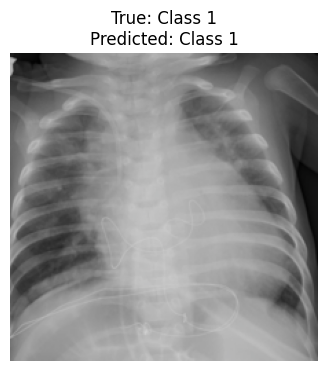

Sample 2: True Class: Class 0, Predicted Class: Class 1


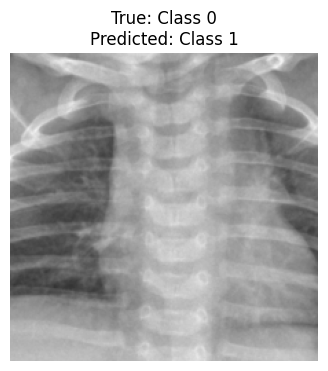

Sample 3: True Class: Class 1, Predicted Class: Class 1


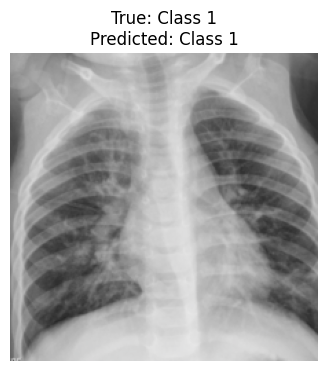

Sample 4: True Class: Class 0, Predicted Class: Class 0


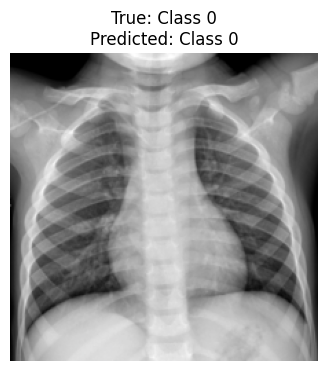

Sample 5: True Class: Class 1, Predicted Class: Class 1


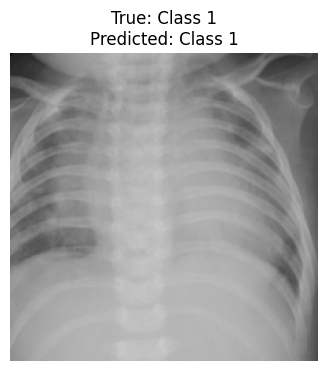

Sample 6: True Class: Class 1, Predicted Class: Class 1


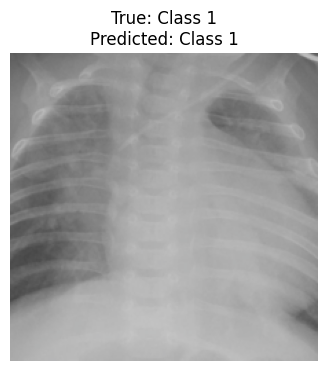

Sample 7: True Class: Class 1, Predicted Class: Class 1


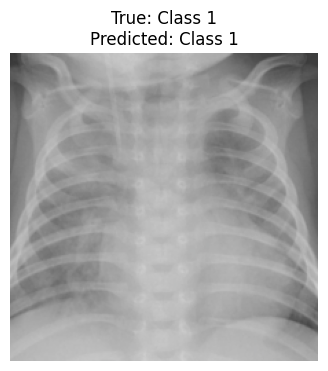

Sample 8: True Class: Class 1, Predicted Class: Class 1


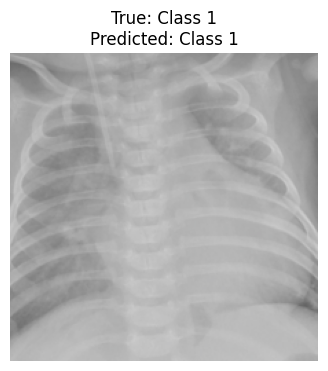

Sample 9: True Class: Class 1, Predicted Class: Class 1


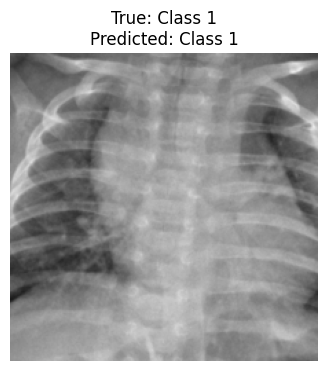

Sample 10: True Class: Class 0, Predicted Class: Class 1


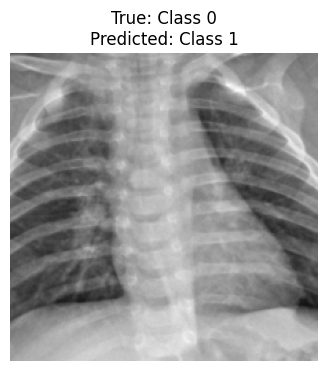

In [7]:
def predict_batch(model, dataloader, device, num_samples=5):
    model.eval()
    predictions = []
    count = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        for i in range(inputs.size(0)):
            if count >= num_samples:
                break
            predictions.append((inputs[i].cpu(), targets[i].item(), predicted[i].item()))
            count += 1
        if count >= num_samples:
            break
    return predictions


num_samples = 10
results = predict_batch(vgg16_model, testloader, device, num_samples=num_samples)

for idx, (image, true_class, predicted_class) in enumerate(results):
    true_class_name = classes.get(true_class, f"Class {true_class}")
    predicted_class_name = classes.get(predicted_class, f"Class {predicted_class}")
    print(f"Sample {idx + 1}: True Class: {true_class_name}, Predicted Class: {predicted_class_name}")
    visualize_sample(image, true_class_name, predicted_class_name)